In [1]:
import tensorflow as tf
from tensorflow import math as tfm
from tensorflow_probability import distributions as tfd
from matplotlib import pyplot as plt
import pandas as pd

from lafomo.datasets import DataHolder, HafnerData
from lafomo.utilities.tf import rotate, logit, logistic, LogisticNormal, inverse_positivity, \
    save_object, discretise
from lafomo.configuration import MCMCConfiguration
from lafomo.mcmc.parameter import Parameter
from lafomo.mcmc.samplers import HMCSampler, LatentGPSampler, DelaySampler, GibbsSampler
from lafomo.mcmc.samplers.mixed import MixedSampler
from lafomo.mcmc.gp.gp_kernels import GPKernelSelector
from lafomo.mcmc.models import MCMCLFM

import numpy as np
import pickle

(2, 1, 13) (1, 22, 13)


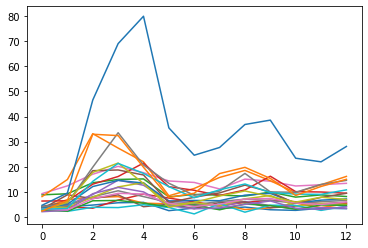

In [2]:
target_genes = [
    'KAZN','PMAIP1','PRKAB1','CSNK1G1','E2F7','SLC30A1',
    'PTP4A1','RAP2B','SUSD6','UBR5-AS1','RNF19B','AEN','ZNF79','XPC',
    'FAM212B','SESN2','DCP1B','MDM2','GADD45A','SESN1','CDKN1A','BTG2'
]
dataset = HafnerData(replicate=0, extra_targets=False, data_dir='../../../data')
num_replicates = 1
num_genes = len(dataset.gene_names)
num_tfs = 1
num_times = dataset[0][0].shape[0]

t_observed = np.arange(0, 13)
t_predict = tf.linspace(0, 13, 80)

m_observed = np.stack([
    dataset[i][1] for i in range(num_genes*num_replicates)
])
m_observed = m_observed.reshape(num_replicates, num_genes, num_times)
m_observed = np.float64(m_observed)
for i in range(m_observed.shape[1]):
    plt.plot(m_observed[0, i])
f_observed = dataset.tfs

t_discretised, common_indices = discretise(t_observed, num_disc=13)
data = DataHolder((m_observed, f_observed),
                  None,
                  (t_observed, t_discretised, tf.constant(common_indices)))

print(f_observed.shape, m_observed.shape)


In [3]:
class TranscriptionRegulationLFM(MCMCLFM):
    """
    An updated version of the Metropolis-Hastings model from Titsias et al. (2012) using a mixed sampler
    """
    def __init__(self, data: DataHolder, options: MCMCConfiguration):
        super().__init__(data, options)
        self.N_p = data.t_discretised.shape[0]
        step_sizes = self.options.initial_step_sizes
        logistic_step_size = step_sizes['nuts'] if 'nuts' in step_sizes else 0.00001
        self.subsamplers = list()
        self.dtype = 'float64'

        basal_rate = Parameter(
            'basal',
            LogisticNormal(0.01, 30),
            tf.random.uniform((self.num_outputs, 1), 0.75, 0.85, dtype=self.dtype),
            transform=logit
        )
        sensitivity = Parameter(
            'sensitivity',
            LogisticNormal(0.01, 30),
            tf.random.uniform((self.num_outputs, 1), 0.75, 0.85, dtype=self.dtype),
            transform=logit
        )
        decay_rate = Parameter(
            'decay',
            LogisticNormal(0.01, 30),
            tf.random.uniform((self.num_outputs, 1), 0.75, 0.85, dtype=self.dtype),
            transform=logit
        )
        kinetics = [basal_rate, decay_rate, sensitivity]

        # Add optional kinetic parameters
        if options.initial_conditions:
            self.initial_conditions = Parameter(
                'initial',
                LogisticNormal(0.01, 30),
                tf.random.uniform((self.num_outputs, 1), 0.75, 0.85, dtype=self.dtype),
                transform=logit
            )
            kinetics.append(self.initial_conditions)
        if options.translation:
            self.protein_decay = Parameter(
                'protein_decay',
                LogisticNormal(0.1, 7),
                0.8 * tf.ones((self.num_tfs, 1), dtype=self.dtype),
                transform=logit
            )
            kinetics.append(self.protein_decay)

        kinetics_subsampler = HMCSampler(self.likelihood, kinetics, logistic_step_size)
        self.subsamplers.append(kinetics_subsampler)

        # Latent function & GP hyperparameters
        self.kernel_selector = GPKernelSelector(data, options)
        kernel_initial = self.kernel_selector.initial_params()

        f_step_size = step_sizes['latents'] if 'latents' in step_sizes else 20
        latent_likelihood = None
        latents_initial = 0.3 * tf.ones((self.num_replicates, self.num_tfs, self.N_p), dtype=self.dtype)

        latents_initial = [latents_initial, *kernel_initial]

        latents = Parameter('latent', None, latents_initial)
        latents_sampler = LatentGPSampler(self.likelihood, latent_likelihood,
                                          latents, self.kernel_selector,
                                          f_step_size*tf.ones(self.N_p, dtype=self.dtype),
                                          kernel_exponential=options.kernel_exponential)

        self.subsamplers.append(latents_sampler)

        # White noise for genes
        if not options.preprocessing_variance:
            def m_sq_diff_fn():
                m_pred = self.predict_m(**self.parameter_state)
                sq_diff = tfm.square(self.data.m_obs - tf.gather(m_pred, self.data.common_indices, axis=2))
                return tf.reduce_sum(sq_diff, axis=0)
            σ2_m = Parameter('σ2_m', tfd.InverseGamma(np.float64(0.01), np.float64(0.01)),
                             1e-3 * tf.ones((self.num_outputs, 1), dtype=self.dtype))
            σ2_m_sampler = GibbsSampler(σ2_m, m_sq_diff_fn, self.N_p)
        else:
            σ2_m = Parameter('σ2_m', LogisticNormal(1e-5, 1),
                             0.7 * tf.ones((self.num_outputs, 1), dtype=self.dtype),
                             transform=logit)
            σ2_m_sampler = HMCSampler(self.likelihood, [σ2_m], logistic_step_size)

        self.subsamplers.append(σ2_m_sampler)

        def iteration_callback(current_state):
            self.parameter_state = current_state

        self.sampler = MixedSampler(self.subsamplers, iteration_callback=iteration_callback)

    def sample(self, T=2000, **kwargs):
        return self.sampler.sample(T, **kwargs)

    # @tf.function
    def calculate_protein(self, fbar, protein_decay, delay):  # Calculate p_i vector
        t_discretised = self.data.t_discretised
        f_i = inverse_positivity(fbar)
        δ_i = tf.reshape(protein_decay, (-1, 1))
        if self.options.delays:
            # Add delay
            delay = tf.cast(delay, 'int32')

            for r in range(self.num_replicates):
                f_ir = rotate(f_i[r], -delay)
                mask = ~tf.sequence_mask(delay, f_i.shape[2])
                f_ir = tf.where(mask, f_ir, 0)
                mask = np.zeros((self.num_replicates, 1, 1), dtype=self.dtype)
                mask[r] = 1
                f_i = (1 - mask) * f_i + mask * f_ir

        # Approximate integral (trapezoid rule)
        resolution = t_discretised[1] - t_discretised[0]
        sum_term = tfm.multiply(tfm.exp(δ_i * t_discretised), f_i)
        cumsum = 0.5 * resolution * tfm.cumsum(sum_term[:, :, :-1] + sum_term[:, :, 1:], axis=2)
        integrals = tf.concat([tf.zeros((self.num_replicates, self.num_tfs, 1), dtype=self.dtype), cumsum], axis=2)
        exp_δt = tfm.exp(-δ_i * t_discretised)
        p_i = exp_δt * integrals
        return p_i

    @tf.function
    def predict_m(self,
                  initial=None, basal=None, decay=None, sensitivity=None,
                  latent=None, **optional_parameters):
        # tf.print(initial, basal, decay, sensitivity)
        if self.options.kinetic_exponential:
            initial = tf.exp(initial)
            basal = tf.exp(basal)
            decay = tf.exp(decay)
            sensitivity = tf.exp(sensitivity)
        # tf.print('p', initial, basal, decay, sensitivity)
        t_discretised = self.data.t_discretised
        fbar = latent[0]
        p_i = inverse_positivity(fbar)

        # Calculate m_pred
        resolution = t_discretised[1] - t_discretised[0]
        if self.options.weights:
            w = optional_parameters['w']
            w_0 = optional_parameters['w_0']
            interactions = tf.matmul(w, tfm.log(p_i + 1e-100)) + w_0
            G = tfm.sigmoid(interactions)  # TF Activation Function (sigmoid)
        else:
            G = tf.tile(p_i, (1, self.num_outputs, 1))

        sum_term = G * tfm.exp(decay * t_discretised)
        integrals = tf.concat([tf.zeros((self.num_replicates, self.num_outputs, 1), dtype=self.dtype),  # Trapezoid rule
                               0.5 * resolution * tfm.cumsum(sum_term[:, :, :-1] + sum_term[:, :, 1:], axis=2)], axis=2)
        exp_dt = tfm.exp(-decay * t_discretised)
        integrals = tfm.multiply(exp_dt, integrals)

        m_pred = basal / decay + sensitivity * integrals
        if self.options.initial_conditions:
            m_pred += tfm.multiply((initial - basal / decay), exp_dt)
        return m_pred

    @tf.function  # (experimental_compile=True)
    def likelihood(self, **parameters):
        """
        Likelihood of the form:
        N(m(t), s(t))
        where m(t) = b/d + (a - b/d) exp(-dt) + s int^t_0 G(p(u); w) exp(-d(t-u)) du
        """
        parameter_state = {**self.parameter_state, **parameters}
        m_pred = self.predict_m(**parameter_state)
        # tf.print('paramstate', parameter_state)
        sq_diff = tfm.square(self.data.m_obs - tf.gather(m_pred, self.data.common_indices, axis=2))

        variance = tf.reshape(parameter_state['σ2_m'], (-1, 1))
        # tf.print(variance)
        if self.preprocessing_variance:
            variance = variance + self.data.σ2_m_pre  # add PUMA variance
        log_lik = -0.5 * tfm.log(2 * np.pi * variance) - 0.5 * sq_diff / variance
        log_lik = tf.reduce_mean(log_lik)
        # print(log_lik)
        return log_lik

    # @tf.function  # (experimental_compile=True)
    def tfs_likelihood(self, **parameters):
        """
        Computes log-likelihood of the transcription factors.
        """
        parameter_state = {**self.parameter_state, **parameters}
        # tf.print(
        #     'param', parameters['latent'],
        #     'self', self.parameter_state['latent'],
        #     'state', parameter_state['latent']
        #  )
        σ2_f = parameter_state['σ2_f']
        latent = parameter_state['latent']

        # assert self.options.tf_mrna_present
        if not self.preprocessing_variance:
            variance = tf.reshape(σ2_f, (-1, 1))
        else:
            variance = self.data.σ2_f_pre
        f_pred = inverse_positivity(latent[0])
        sq_diff = tfm.square(self.data.f_obs - tf.transpose(tf.gather(tf.transpose(f_pred), self.data.common_indices)))
        log_lik = -0.5 * tfm.log(2 * np.pi * variance) - 0.5 * sq_diff / variance
        log_lik = tf.reduce_sum(log_lik)

        return log_lik

    def sample_proteins(self, results, num_results):
        p_samples = list()
        for i in range(1, num_results + 1):
            delta = results['delay'][i] if results['delay'] is not None else None
            p_samples.append(self.likelihood.calculate_protein(results.fbar[-i],
                                                               results.k_fbar[-i], delta))
        return np.array(p_samples)

    def sample_latents(self, results, num_results, step=1):
        m_preds = list()
        for i in range(1, num_results, step):
            m_preds.append(self.predict_m_with_results(results, i))
        return np.array(m_preds)

    def results(self, burnin=0):
        results = dict()
        for i, subsampler in enumerate(self.subsamplers):
            group_samples = self.sampler.samples[i]
            for j, param in enumerate(subsampler.param_group):
                samples = group_samples[j]
                if type(samples) is list:
                    samples = [s.numpy()[-burnin:] for s in samples]
                else:
                    samples = samples.numpy()[-burnin:]
                results[param.name] = param.transform(samples)

        return results

    def predict_m_with_results(self, results, i=1):
        parameter_state = self.parameter_state
        for key in results:
            result = results[key]
            if type(result) is list:
                parameter_state[key] = [result[0][-1]]
            else:
                parameter_state[key] = result[-1]
        return self.predict_m(**parameter_state)

    def save(self, name):
        save_object({'samples': self.samples, 'is_accepted': self.is_accepted}, f'custom-{name}')

    @staticmethod
    def load(name, args):
        model = TranscriptionRegulationLFM(*args)

        import os
        path = os.path.join(os.getcwd(), 'saved_models')
        fs = [os.path.join(path, f) for f in os.listdir(path) if f.startswith(f'custom-{name}')]
        files = sorted(fs, key=os.path.getmtime)
        with open(files[-1], 'rb') as f:
            saved_model = pickle.load(f)
            model.samples = saved_model['samples']
            model.is_accepted = saved_model['is_accepted']
        for param in model.active_params:
            index = model.state_indices[param.name]
            param_samples = model.samples[index]
            if type(param_samples) is list:
                param_samples = [[param_samples[i][-1] for i in range(len(param_samples))]]

            param.value = param_samples[-1]

        return model

    @staticmethod
    def initialise_from_state(args, state):
        model = TranscriptionRegulationLFM(*args)
        model.is_accepted = state.is_accepted
        model.samples = state.samples
        return model


In [4]:
opt = MCMCConfiguration(
    preprocessing_variance=False,
    initial_conditions=False,
    translation=False,
    latent_data_present=False,
    delays=False,
    weights=False,
    kinetic_exponential=False,
    initial_step_sizes={'nuts': 0.000005, 'latents': 10},
    kernel='rbf'
)

model = TranscriptionRegulationLFM(data, opt)


In [6]:
# start = timer()
model.sample(T=500, burn_in=0)
# end = timer()
# print(f'Time taken: {(end - start):.04f}s')
is_accepted = model.sampler.is_accepted

pcs = list()
for i, subsampler in enumerate(model.subsamplers):
    pcs.append(tf.reduce_mean(tf.cast(is_accepted[i], dtype=tf.float32)).numpy())

display(pd.DataFrame([[f'{100*pc:.02f}%' for pc in pcs]], columns=list(model.subsamplers)))

----- Sampling Begins -----
Preparing HMCSampler ['basal', 'decay', 'sensitivity']
Preparing LatentGPSampler ['latent']
Preparing GibbsSampler ['σ2_m']
Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.
Progress: 	 100%	| "==================="""| 
----- Finished -----


,"HMCSampler ['basal', 'decay', 'sensitivity']",LatentGPSampler ['latent'],GibbsSampler ['σ2_m']
0,88.20%,11.60%,100.00%


In [8]:
results = model.results(100)

In [17]:
parameter_state = model.parameter_state
print(parameter_state['basal'])
print(results['basal'][-1])
for key in results:
    print(key)
    result = results[key]
    print(type(result))
    if type(result) is list:
        parameter_state[key] = [result[0][-1]]
    else:
        parameter_state[key] = result[-1]

tf.Tensor(
[[1.8051886 ]
 [1.90762244]
 [2.48468264]
 [1.97775734]
 [1.68681805]
 [2.10224175]
 [7.50505598]
 [1.73193684]
 [1.51441827]
 [1.97258954]
 [2.22270371]
 [2.68609905]
 [1.34592366]
 [2.0124069 ]
 [1.66338659]
 [2.49246019]
 [1.63251596]
 [2.30544192]
 [3.55304126]
 [3.09590127]
 [9.90066447]
 [3.70819485]], shape=(22, 1), dtype=float64)
tf.Tensor(
[[1.8051886 ]
 [1.90762244]
 [2.48468264]
 [1.97775734]
 [1.68681805]
 [2.10224175]
 [7.50505598]
 [1.73193684]
 [1.51441827]
 [1.97258954]
 [2.22270371]
 [2.68609905]
 [1.34592366]
 [2.0124069 ]
 [1.66338659]
 [2.49246019]
 [1.63251596]
 [2.30544192]
 [3.55304126]
 [3.09590127]
 [9.90066447]
 [3.70819485]], shape=(22, 1), dtype=float64)
basal
<class 'tensorflow.python.framework.ops.EagerTensor'>
decay
<class 'tensorflow.python.framework.ops.EagerTensor'>
sensitivity
<class 'tensorflow.python.framework.ops.EagerTensor'>
latent
<class 'list'>
σ2_m
<class 'numpy.ndarray'>


In [38]:
# model.sampler.before_iteration(model.sampler.initial_state)
# # print(model.parameter_state)
# model.likelihood(**model.parameter_state)
from lafomo.plot.mcmc_plotters import Plotter, PlotOptions
plot_opt = PlotOptions(
    num_plot_genes=10, num_plot_tfs=10,
    gene_names=np.array(dataset.gene_names), tf_names=np.array(['p53']),
    true_label='Hafner et al.', for_report=False, ylabel='normalised FPKM',
    kernel_names=model.kernel_selector.names(), num_hpd=200, tf_present=False
)
plotter = Plotter(data, plot_opt)

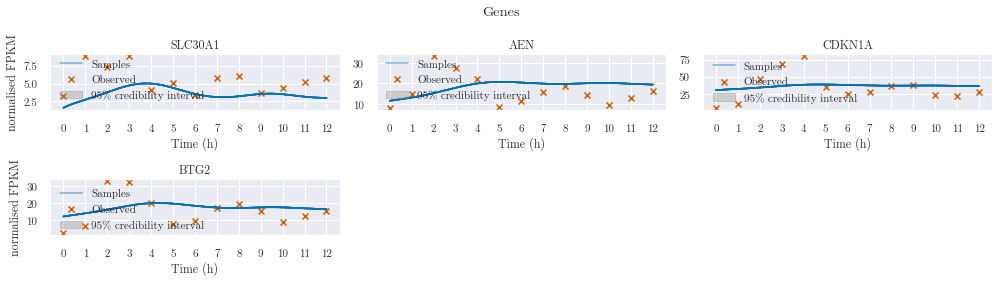

In [39]:
m_preds = model.sample_latents(results, 20)

plotter.plot_outputs(m_preds, replicate=0, height_mul=2, indices=[5, 11, 20, 21])

tf.Tensor(
[[[1.22398805]
  [1.62801145]
  [1.73645361]
  ...
  [2.33986875]
  [9.7839538 ]
  [6.08697123]]

 [[1.22398805]
  [1.62801145]
  [1.73645361]
  ...
  [2.33986875]
  [9.7839538 ]
  [6.08697123]]

 [[1.22398805]
  [1.62801145]
  [1.73645361]
  ...
  [2.33986875]
  [9.7839538 ]
  [6.08697123]]

 ...

 [[1.22445739]
  [1.62801942]
  [1.73613704]
  ...
  [2.33992786]
  [9.77195386]
  [6.06995237]]

 [[1.22445739]
  [1.62801942]
  [1.73613704]
  ...
  [2.33992786]
  [9.77195386]
  [6.06995237]]

 [[1.22445739]
  [1.62801942]
  [1.73613704]
  ...
  [2.33992786]
  [9.77195386]
  [6.06995237]]], shape=(100, 22, 1), dtype=float64)


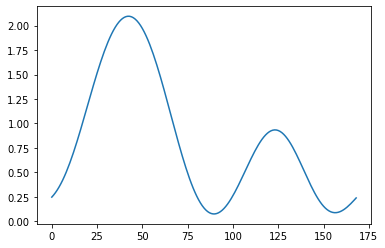

In [30]:
plt.plot(results['latent'][0][-1][0, 0])
print(results['basal'])

m_pred = model.predict_m_with_results(results)

(2, 22, 169)
tf.Tensor([0.19524908], shape=(1,), dtype=float64)


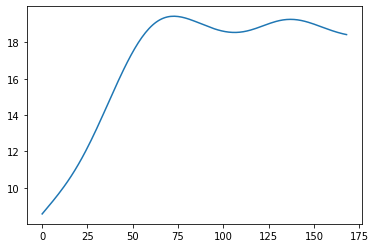

In [37]:
print(m_pred.shape)
print(results['decay'][-1][6])
plt.plot(m_pred[0,6])

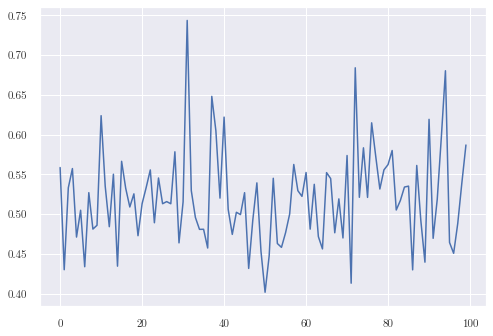

In [42]:
plt.plot(results['σ2_m'][:, 0])
